In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz && tar xf spark-3.0.3-bin-hadoop2.7.tgz
!pip install pyspark==3.0.3 findspark

--2024-08-25 11:27:18--  https://dlcdn.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-08-25 11:27:18 ERROR 404: Not Found.



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, length, lit, lower, regexp_replace, size, split, filter, udf, sum, when
from pyspark.sql.types import ArrayType,StringType, FloatType, StructType, StructField

from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vector
from pyspark.ml.functions import vector_to_array

ImportError: cannot import name 'filter' from 'pyspark.sql.functions' (/usr/local/lib/python3.10/dist-packages/pyspark/sql/functions.py)

# `Creating Spark Environment`

In [ ]:
# Create a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Restaurant Reviews") \
    .master("local[8]") \
    .config("spark.executor.memory", "10g") \
    .config("spark.executor.cores", "3") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()


# .config("spark.memory.offHeap.enabled","true")
# .config("spark.memory.offHeap.size","10g")


In [ ]:
conf = spark.sparkContext.getConf()

# Print the configuration settings
print("spark.app.name = ", conf.get("spark.app.name"))
print("spark.master = ", conf.get("spark.master"))
print("spark.executor.memory = ", conf.get("spark.executor.memory"))
print("spark.executor.cores = ", conf.get("spark.executor.cores")),
print("spark.driver.memory = ", conf.get("spark.driver.memory"))
print("spark.rpc.message.maxSize = ", conf.get("spark.rpc.message.maxSize"))
print("spark.kryoserializer.buffer.max = ", conf.get("spark.kryoserializer.buffer.max"))

spark.app.name =  Restaurant Reviews
spark.master =  local[8]
spark.executor.memory =  10g
spark.executor.cores =  3
spark.driver.memory =  2g
spark.rpc.message.maxSize =  None
spark.kryoserializer.buffer.max =  None


## Data Preprocessing




In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip  '/content/drive/MyDrive/hadoop/datareviewforbigdata.zip' -d '/content/data'

Archive:  /content/drive/MyDrive/hadoop/datareviewforbigdata.zip
replace /content/data/yelp_academic_dataset_review.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/data/yelp_academic_dataset_review.json  y
y



In [ ]:
# Source file pathways on local disk
path_data= "/content/data/yelp_academic_dataset_review.json"


In [ ]:
data = spark.read.json(path_data)

In [ ]:
data.show(n=10, truncate=10)

+-----------+----+----------+-----+----------+-----+----------+------+----------+
|business_id|cool|      date|funny| review_id|stars|      text|useful|   user_id|
+-----------+----+----------+-----+----------+-----+----------+------+----------+
| XQfwVwD...|   0|2018-07...|    0|KU_O5ud...|  3.0|If you ...|     0|mh_-eMZ...|
| 7ATYjTI...|   1|2012-01...|    0|BiTunyQ...|  5.0|I've ta...|     1|OyoGAe7...|
| YjUWPpI...|   0|2014-02...|    0|saUsX_u...|  3.0|Family ...|     0|8g_iMtf...|
| kxX2SOe...|   1|2015-01...|    0|AqPFMle...|  5.0|Wow!  Y...|     1|_7bHUi9...|
| e4Vwtrq...|   1|2017-01...|    0|Sx8TMOW...|  4.0|Cute in...|     1|bcjbaE6...|
| 04UD14g...|   1|2015-09...|    2|JrIxlS1...|  1.0|I am a ...|     1|eUta8W_...|
| gmjsEdU...|   0|2015-01...|    2|6AxgBCN...|  5.0|Loved t...|     0|r3zeYsv...|
| LHSTtnW...|   0|2015-08...|    0|_ZeMknu...|  5.0|Amazing...|     2|yfFzsLm...|
| B5XSoSG...|   0|2016-03...|    1|ZKvDG2s...|  3.0|This ea...|     1|wSTuiTk...|
| gebiRew...|   

In [ ]:
data.head(10)

[Row(business_id='XQfwVwDr-v0ZS3_CbbE5Xw', cool=0, date='2018-07-07 22:09:11', funny=0, review_id='KU_O5udG6zpxOg-VcAEodg', stars=3.0, text="If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.", useful=0, user_id='mh_-eMZ6K5RLWhZyISBhwA'),
 Row(business_id='7ATYjTIgM3jUlt4UM3IypQ', cool=1, date='2012-01-03 15:28:18', funny=0, review_id='BiTunyQ73aT9WBnpR9DZGw', stars=5.0, text="I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the we

In [ ]:
data.tail(10)

[Row(business_id='1_BVWDzi5cVqWxNe9bOMMQ', cool=1, date='2016-04-30 01:02:34', funny=0, review_id='7NgXAuTFiJHYbuepOPwU0w', stars=5.0, text="Don't misinterpret my 5-star review....I don't think Wendy's is a good substitute for the amazing family-owned restaurants located in the area. The 5 stars is solely related to the fact that this is the BEST Wendy's I have ever been to.\n\nWhen I'm super lazy (which is most days), I go through the drive thru for a quick dinner on my ride home. No matter how many cars are in the drive thru lane, they seem to process them like a machine. The staff are always friendly and my food comes out hot.\n\nA few weeks ago, I decided to venture inside. It felt like I had landed in outer space. I have NEVER seen such a fancy Wendy's. There is a two-sided fireplace with four upholstered chairs on one side. They also have TV, free wifi, and a soda machine that makes 100s of sodas. \n\nI most certainly will continue to visit this Wendy's. One of the best (if not t

In [ ]:
# Show schema
data.printSchema()

# Count the number of rows
print(f"Tổng số hàng bình luận: {data.count()}")

# Show a few sample rows
data.select("business_id", "stars", "text", "date").show(5, truncate=False)

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Tổng số hàng bình luận: 6990280
+----------------------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import col, to_date, length

# Drop duplicates and rows with nulls in critical columns
data = data.dropDuplicates(['review_id']) \
    .dropna(subset=['review_id', 'user_id', 'business_id', 'stars', 'text', 'date'])

In [ ]:

# Filter out reviews with invalid star ratings (if any)
data = data.filter((col('stars') >= 1) & (col('stars') <= 5))

In [ ]:
# Convert 'date' column to DateType
data = data.withColumn('date', to_date(col('date'), 'yyyy-MM-dd HH:mm:ss'))

In [ ]:
# Create a 'review_length' column
data = data.withColumn('review_length', length(col('text')))

In [ ]:
# Verify the cleaned data
data.select(['review_id', 'user_id', 'business_id', 'stars', 'date', 'review_length']).show(5)

+--------------------+--------------------+--------------------+-----+----------+-------------+
|           review_id|             user_id|         business_id|stars|      date|review_length|
+--------------------+--------------------+--------------------+-----+----------+-------------+
|--1z0MjmPFmNQLpnw...|xg36DnPGqxPfGZN1q...|BryQISFnkCdcJET-t...|  4.0|2015-06-20|         1490|
|--6RL5X9PiswVnpKK...|l2qhjxdNQeEAn3yPj...|I_mCFePUG2MGuH-zu...|  5.0|2016-04-13|          361|
|--7f0VAcFgpK3Hz8u...|ATZPb63VYwJXa3biM...|p2yZcS_C-TjlEUXrL...|  4.0|2018-03-25|          169|
|--CQtyFgZgR5LAGsp...|bGSdyBiaARMCdGTJg...|Auc20f0uYTIwPnJIq...|  2.0|2011-08-07|          461|
|--DcWXBx2ei_ME39L...|11yiaQf8NGEVFjk2e...|2EOinQpyU4ChpyJ4K...|  4.0|2019-03-19|          132|
+--------------------+--------------------+--------------------+-----+----------+-------------+
only showing top 5 rows



Giải thích:

  Xóa trùng lặp: Đảm bảo mỗi đánh giá là duy nhất.

  Xử lý Null: Xóa các hàng thiếu thông tin cần thiết.

  Chuyển đổi ngày: Chuyển đổi ngày chuỗi thành DateType thích hợp để phân tích theo thời gian.

  Độ dài đánh giá: Thêm một cột để phân tích độ dài văn bản.

Xác thực xếp hạng sao: Đảm bảo xếp hạng sao nằm trong phạm vi hợp lệ.

analysis

In [ ]:
# Compute basic statistics
data.describe(['stars', 'useful', 'funny', 'cool', 'review_length']).show()

+-------+------------------+------------------+-------------------+------------------+-----------------+
|summary|             stars|            useful|              funny|              cool|    review_length|
+-------+------------------+------------------+-------------------+------------------+-----------------+
|  count|           6990280|           6990280|            6990280|           6990280|          6990280|
|   mean|  3.74858374771826|1.1846089140921394|0.32655959417934616|0.4986175088837643|567.7644364746477|
| stddev|1.4787045052556842| 3.253766966933358|  1.688729098554045|2.1724598202111847|527.2578085249025|
|    min|               1.0|                -1|                 -1|                -1|                1|
|    max|               5.0|              1182|                792|               404|             5000|
+-------+------------------+------------------+-------------------+------------------+-----------------+



Giải thích:

Cung cấp giá trị đếm, giá trị trung bình, độ lệch chuẩn, giá trị min và giá trị max cho các cột số đã chọn.

In [ ]:
# Group by stars and count the number of reviews
stars_distribution = data.groupBy("stars").count().orderBy("stars")
from pyspark.sql.functions import avg

# Calculate average star rating per business
avg_stars_per_business = data.groupBy("business_id").agg(avg("stars").alias("avg_stars"))

# Calculate average star rating per year
data = data.withColumn("year", col("date").substr(1, 4).cast("int"))
avg_stars_per_year = data.groupBy("year").agg(avg("stars").alias("avg_stars"))

In [ ]:
from pyspark.sql.functions import count

# Calculate the count and percentage of each star rating
star_distribution = data.groupBy('stars').agg(
    count('*').alias('count')
).orderBy('stars')

total_reviews = data.count()
star_distribution = star_distribution.withColumn(
    'percentage',
    (col('count') / total_reviews * 100).cast('decimal(4,2)')
)



Giải thích:

Hiển thị cách phân phối đánh giá trên các xếp hạng sao khác nhau.
Giúp xác định xem dữ liệu có thiên về đánh giá tích cực hay tiêu cực không.

In [ ]:
!pip install textblob
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Define a UDF to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Register the UDF
sentiment_udf = udf(get_sentiment, FloatType())

# Apply the UDF to calculate sentiment for each review
data = data.withColumn("sentiment", sentiment_udf(data.text))

# Show the sentiment scores
data.select("text", "sentiment").show(5)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 3.5 MB/s eta 0:00:00
+--------------------+----------+
|                text| sentiment|
+--------------------+----------+
|I brought my fami...|0.23030953|
|You really cant b...|0.37465277|
|Excellent service...|0.39962962|
|I was visiting th...| 0.3719697|
|Good stuff even f...|0.46666667|
+--------------------+----------+
only showing top 5 rows



In [ ]:
import pandas as pd


# Group by stars and calculate average sentiment
sentiment_by_star = data.groupBy("stars").agg(avg("sentiment").alias("avg_sentiment"))

# Convert to Pandas DataFrame
sentiment_by_star_pd = sentiment_by_star.toPandas()

<ipython-input-26-3e40a67e9286>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='stars', y='avg_sentiment', data=sentiment_by_star_pd, palette="Blues_d")


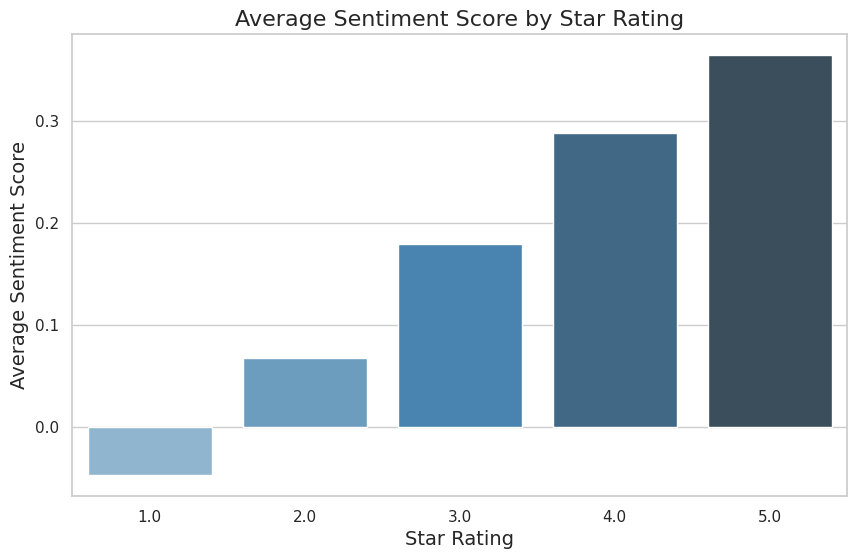

In [ ]:
#Visualize Average Sentiment by Star Rating
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Plot average sentiment by star rating
plt.figure(figsize=(10, 6))
sns.barplot(x='stars', y='avg_sentiment', data=sentiment_by_star_pd, palette="Blues_d")

# Adding title and labels
plt.title('Average Sentiment Score by Star Rating', fontsize=16)
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)

# Display the plot
plt.show()

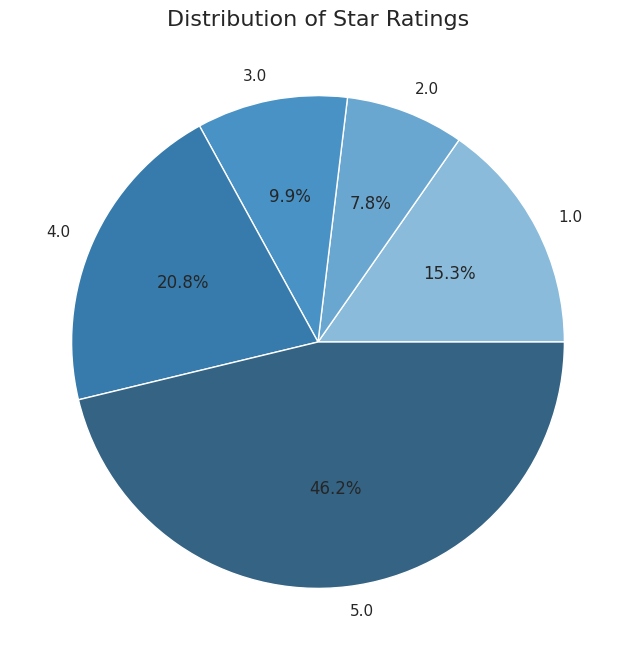

In [ ]:
# Convert star distribution to Pandas
star_distribution_pd = star_distribution.toPandas()

# Plot pie chart of star distribution
plt.figure(figsize=(8, 8))
plt.pie(star_distribution_pd['count'], labels=star_distribution_pd['stars'],
        autopct='%1.1f%%', colors=sns.color_palette("Blues_d"))

# Adding title
plt.title('Distribution of Star Ratings', fontsize=16)

# Display the plot
plt.show()

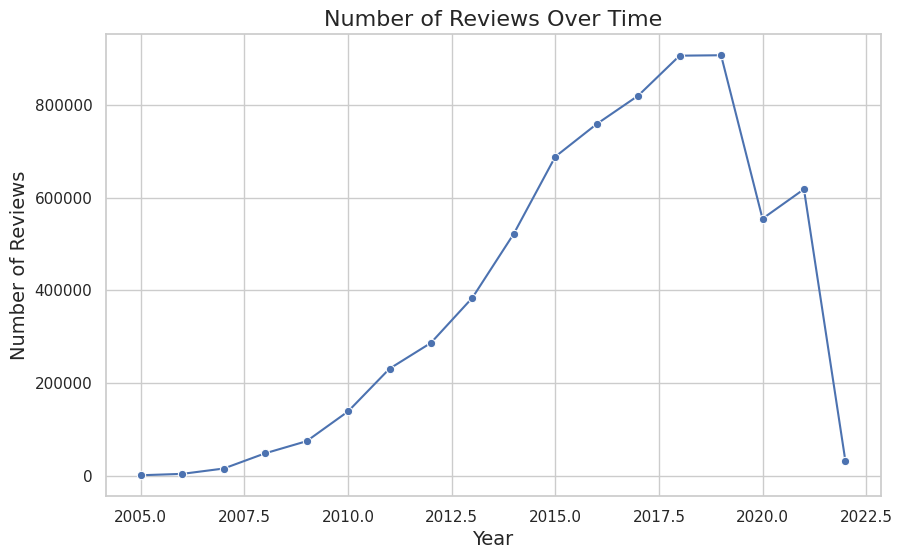

In [ ]:
# Convert reviews_per_year to Pandas
reviews_per_year = data.groupBy('year').count().orderBy('year')
reviews_per_year_pd = reviews_per_year.toPandas()

# Plot number of reviews over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='count', data=reviews_per_year_pd, marker='o')

# Adding title and labels
plt.title('Number of Reviews Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)

# Display the plot
plt.show()

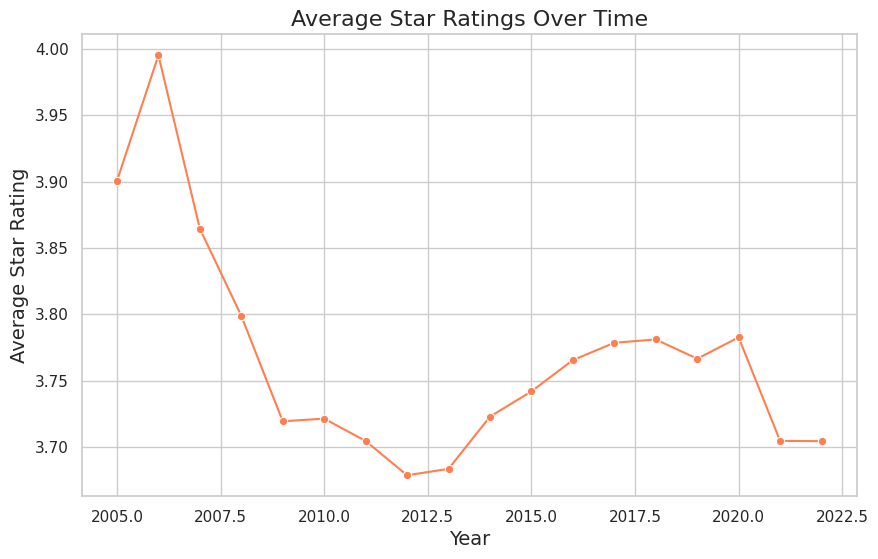

In [ ]:
# Convert avg_stars_per_year to Pandas
avg_stars_per_year_pd = avg_stars_per_year.toPandas()

# Plot average star ratings over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='avg_stars', data=avg_stars_per_year_pd, marker='o', color='coral')

# Adding title and labels
plt.title('Average Star Ratings Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Star Rating', fontsize=14)

# Display the plot
plt.show()

transformations

models

In [ ]:
drop_list = ['business_id', 'cool', 'date', 'funny', 'review_id', 'useful', 'user_id']
data_preprocessed = data.select([column for column in data.columns if column not in drop_list])
data_preprocessed.show(5)

+-----+--------------------+
|stars|                text|
+-----+--------------------+
|  3.0|If you decide to ...|
|  5.0|I've taken a lot ...|
|  3.0|Family diner. Had...|
|  5.0|Wow!  Yummy, diff...|
|  4.0|Cute interior and...|
+-----+--------------------+
only showing top 5 rows



In [ ]:

from pyspark.sql.functions import when, col, lit

data_preprocessed = data_preprocessed.withColumn('Feeling', when(col('stars') >= 3, lit(1)).otherwise(lit(0)))
data_preprocessed.show()


+-----+--------------------+-------+
|stars|                text|Feeling|
+-----+--------------------+-------+
|  3.0|If you decide to ...|      1|
|  5.0|I've taken a lot ...|      1|
|  3.0|Family diner. Had...|      1|
|  5.0|Wow!  Yummy, diff...|      1|
|  4.0|Cute interior and...|      1|
|  1.0|I am a long term ...|      0|
|  5.0|Loved this tour! ...|      1|
|  5.0|Amazingly amazing...|      1|
|  3.0|This easter inste...|      1|
|  3.0|Had a party of 6 ...|      1|
|  5.0|My experience wit...|      1|
|  4.0|Locals recommende...|      1|
|  4.0|Love going here f...|      1|
|  4.0|Good food--loved ...|      1|
|  4.0|The bun makes the...|      1|
|  5.0|Great place for b...|      1|
|  5.0|Tremendous servic...|      1|
|  4.0|The hubby and I h...|      1|
|  5.0|I go to blow bar ...|      1|
|  5.0|My absolute favor...|      1|
+-----+--------------------+-------+
only showing top 20 rows



In [ ]:
data_preprocessed = data_preprocessed.select(['text', 'Feeling'])
data_preprocessed.show()


+--------------------+-------+
|                text|Feeling|
+--------------------+-------+
|If you decide to ...|      1|
|I've taken a lot ...|      1|
|Family diner. Had...|      1|
|Wow!  Yummy, diff...|      1|
|Cute interior and...|      1|
|I am a long term ...|      0|
|Loved this tour! ...|      1|
|Amazingly amazing...|      1|
|This easter inste...|      1|
|Had a party of 6 ...|      1|
|My experience wit...|      1|
|Locals recommende...|      1|
|Love going here f...|      1|
|Good food--loved ...|      1|
|The bun makes the...|      1|
|Great place for b...|      1|
|Tremendous servic...|      1|
|The hubby and I h...|      1|
|I go to blow bar ...|      1|
|My absolute favor...|      1|
+--------------------+-------+
only showing top 20 rows



In [ ]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml import Pipeline

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\W")
# stop words
add_stopwords = ["http","https","amp","rt","t","c","the"]
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)
# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data_preprocessed)
dataset = pipelineFit.transform(data_preprocessed)
dataset.show(5)

+--------------------+-------+--------------------+--------------------+--------------------+
|                text|Feeling|               words|            filtered|            features|
+--------------------+-------+--------------------+--------------------+--------------------+
|If you decide to ...|      1|[if, you, decide,...|[if, you, decide,...|(10000,[0,1,2,3,5...|
|I've taken a lot ...|      1|[i, ve, taken, a,...|[i, ve, taken, a,...|(10000,[0,1,2,3,5...|
|Family diner. Had...|      1|[family, diner, h...|[family, diner, h...|(10000,[2,3,6,7,1...|
|Wow!  Yummy, diff...|      1|[wow, yummy, diff...|[wow, yummy, diff...|(10000,[0,6,8,9,1...|
|Cute interior and...|      1|[cute, interior, ...|[cute, interior, ...|(10000,[0,1,3,6,1...|
+--------------------+-------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:

(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Specify the label column explicitly
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0, labelCol='Feeling')  # Assuming 'Feeling' is your label column
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)

In [ ]:
print(predictions)

DataFrame[text: string, Feeling: int, words: array<string>, filtered: array<string>, features: vector, rawPrediction: vector, probability: vector, prediction: double]


In [18]:
predictions.show()

+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|Feeling|               words|            filtered|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|" my taste buds w...|      1|[my, taste, buds,...|[my, taste, buds,...|(10000,[0,1,4,5,6...|[-3.3299705568201...|[0.03455721258596...|       1.0|
|"Beeeeeeeessttt i...|      1|[beeeeeeeessttt, ...|[beeeeeeeessttt, ...|(10000,[0,1,2,3,4...|[-2.4389128593358...|[0.08025312019620...|       1.0|
|"Beep beep beep. ...|      1|[beep, beep, beep...|[beep, beep, beep...|(10000,[0,2,3,5,6...|[-2.0164576344772...|[0.11748577611509...|       1.0|
|"CLOSED"; Saw Yak...|      0|[closed, saw, yak...|[closed, saw, yak...|(10000,[0,3,5,7,1...|[0.12634276777653...|[0.5

In [24]:

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Feeling", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Độ chính xác của mo hình {accuracy:.2f}")

Độ chính xác của mo hình 0.89


In [28]:
# Evaluate the model using ROC AUC metric
evaluator = BinaryClassificationEvaluator(labelCol='Feeling', metricName='areaUnderROC')
roc_auc = evaluator.evaluate(predictions)

# Extract the ROC Curve data points from the model's summary
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()





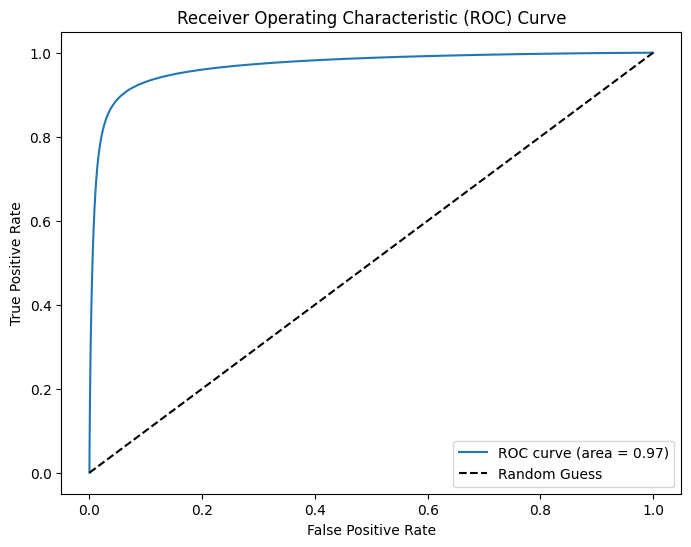

In [30]:
plt.figure(figsize=(8, 6))

# Vẽ đường cong ROC sử dụng False Positive Rate (FPR) và True Positive Rate (TPR)
plt.plot(roc['FPR'], roc['TPR'], label=f'ROC curve (area = {roc_auc:.2f})')

# Vẽ đường chéo biểu thị cho việc đoán ngẫu nhiên
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Đặt nhãn cho trục x và trục y
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Đặt tiêu đề cho biểu đồ
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Hiển thị chú thích (legend) ở góc dưới bên phải
plt.legend(loc='lower right')

# Hiển thị biểu đồ
plt.show()